# Hardware synthesis exercise #1: Blinky

We create the classic blinky design: a flashing LED setup for a Lattice ECP5 FPGA target.
Design elements:

* A clock generator (on chip)
* A cycle counter
* Flipflop toggle logic

In [1]:
import config

## Clock sourcing: The OSCG blackbox

This is an architecture specific on-chip oscillator that can be parametrized with a simple divider.
It is a true hardware primitive built-in in the ECP5 FPGA, thus resolved as a blackbox at the PnR stage.

**Sidenote:** There are Verilog models available for some primitives to simulate their behaviour

## A blinker unit

In [2]:
from myhdl import *

# Import architecture specific components:
from synthesis.yosys.ecp5.components import OSCG, CLKDIVF

@block
def blinker(clk, led_toggle, reset_n, INTERVAL):
    "Portable blinker logic using an interval counter"
    counter = Signal(intbv(0)[32:])
    
    @always_seq(clk.posedge, reset_n)
    def worker():
        counter.next = counter + 1
        if counter == INTERVAL:
            led_toggle.next = not led_toggle
            counter.next = 0
            
    return instances()

## Top level design entity

We create a top level design module as follows. Its input/output ports are the true hardware ports as described in the physical I/O constraints file (`*.lpf`). The hardware specific board configuration files are found in [boards/](boards).

In [3]:
@block
def toplevel(clk_in, reset_n, uart_rxd, uart_txd, led, INTERVAL):
    "Top level entity with UART hard loopback"
    
    toggle_led0, toggle_led1 = [ Signal(bool()) for i in range(2) ]

    oclk, dclk = [ Signal(bool()) for i in range(2) ]
    
    l_out = Signal(intbv()[8:])

    # Use the oscillator clock, a Divider of 31 is approx 10 MHz
    osc_inst = OSCG(oclk, DIV=31)
    clkdiv_inst = CLKDIVF(oclk, 0, 0, dclk, DIV="2.0")
    # Instance two blinkers:
    blink0_inst = blinker(oclk, toggle_led0, reset_n, INTERVAL)
    blink1_inst = blinker(dclk, toggle_led1, reset_n, INTERVAL)

    @always_comb
    def assign_out():
        led.next = not l_out # Output inverted
        uart_txd.next =  uart_rxd # UART hard loopback
            
    @always_comb
    def assign():
        "LED assignment"
        l_out.next = concat(False, toggle_led1, False, False, True, False, toggle_led0, False)
    
    return instances()

## Translate design

In [4]:
from myhdl.conversion import yshelper

clk_in = Signal(bool())
uart_rxd, uart_txd = [ Signal(bool()) for i in range(2) ]
led = Signal(modbv()[8:])
reset_n = ResetSignal(1, 0, False)

blinky = toplevel(clk_in, reset_n, uart_rxd, uart_txd, led, 10000000)

design = yshelper.Design("blinky")
blinky.convert("yosys_module", design)

design.finalize("top")

CREATE Module: 'OSCG_0'
	Infer blackbox: 'OSCG_0'
Adding module with name: OSCG_1
config param DIV = 31
Adding module with name: OSCG
KEYWORD VAR **parameter
CREATE Module: 'CLKDIVF_0'
	Infer blackbox: 'CLKDIVF_0'
Adding module with name: CLKDIVF_1_c0_c0_1
config param DIV = 2.0
Adding module with name: CLKDIVF
KEYWORD VAR **parameter
CREATE Module: 'blinker_0'
Adding module with name: blinker_1_1_1_c10000000
CONVERT_RTL tree >>>>>> 'TOPLEVEL_BLINKER_0_WORKER' 
TRUNC: <ipython-input-2-2d576fc99264>:13 Implicit carry truncate: counter[32:], src[33:]
DONE instancing submodules
CREATE Module: 'blinker_1'
CREATE Module: 'toplevel'
Adding module with name: toplevel_1_1_1_1_8_c10000000
CONVERT_RTL tree >>>>>> 'TOPLEVEL_ASSIGN_OUT' 
CONVERT_RTL tree >>>>>> 'TOPLEVEL_ASSIGN' 
++++++++ OSCG_0: OSCG_1 (Module) ++++++++
++++++++ CLKDIVF_0: CLKDIVF_1_c0_c0_1 (Module) ++++++++
++++++++ blinker_0: blinker_1_1_1_c10000000 (Module) ++++++++
Unused signal: clk_in
++++++++ blinker_1: blinker_1_1_1_c1000

### RTL display

Generating RTL image...
Display...


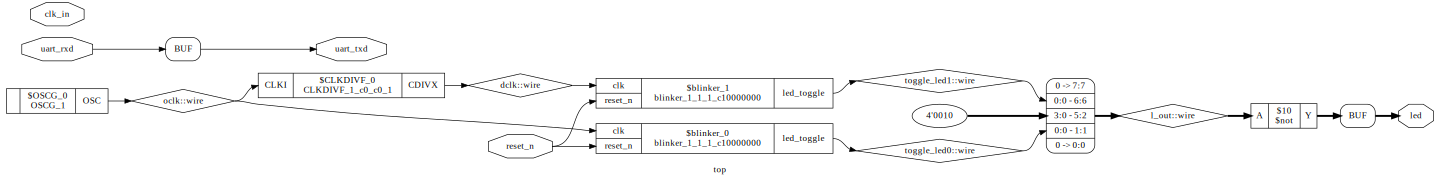

In [5]:
from ys_aux import *
display(to_svg(design, "top", 200 ))

## Technology mapping to ECP5

The long command sequence for a ECP5 target was moved into a rules class. We call these rules using an auxiliary script:

In [6]:
from ecp5aux import synthesize

synthesize(design)

## PnR stage: Place and route

Write out the JSON file for the PnR step:

In [7]:
json_filename = "design.json"

design.run("write_json %s" % json_filename)
# Output of RTLIL for debugging purposes:
# design.run("write_ilang design.il")

### Running nextpnr

In [8]:
! nextpnr-ecp5 --json design.json --um5g-45k\
    --lpf boards/ecp5_versa.lpf --freq 100 --lpf-allow-unconstrained\
    --textcfg design.config --package=CABGA381

Info: constraining clock net 'clk_in' to 100.00 MHz

Info: Logic utilisation before packing:
Info:     Total LUT4s:       237/43848     0%
Info:         logic LUTs:    173/43848     0%
Info:         carry LUTs:     64/43848     0%
Info:           RAM LUTs:      0/21924     0%
Info:          RAMW LUTs:      0/10962     0%

Info:      Total DFFs:       132/43848     0%

Info: Packing IOs..
Info: pin 'clk_in$tr_io' constrained to Bel 'X0/Y68/PIOC'.
Info: pin 'reset_n$tr_io' constrained to Bel 'X4/Y71/PIOB'.
Info: pin 'uart_rxd$tr_io' constrained to Bel 'X38/Y0/PIOB'.
Info: pin 'uart_txd$tr_io' constrained to Bel 'X36/Y0/PIOB'.
Info: pin 'led[6]$tr_io' constrained to Bel 'X90/Y14/PIOB'.
Info: pin 'led[1]$tr_io' constrained to Bel 'X90/Y11/PIOB'.
Info: pin 'led[0]$tr_io' constrained to Bel 'X90/Y11/PIOC'.
Info: pin 'led[2]$tr_io' constrained to Bel 'X90/Y14/PIOA'.
Info: pin 'led[3]$tr_io' constrained to Bel 'X90/Y14/PIOC'.
Info: pin 'led[4]$tr_io' constrained to Bel 'X90/Y17/PIOA'.
Info: pi

Info:     at iteration #13, type CLKDIVF: wirelen solved = 980, spread = 980, legal = 1035; time = 0.00s
Info:     at iteration #13, type OSCG: wirelen solved = 1018, spread = 1018, legal = 1035; time = 0.00s
Info:     at iteration #13, type TRELLIS_SLICE: wirelen solved = 631, spread = 803, legal = 1103; time = 0.01s
Info:     at iteration #13, type ALL: wirelen solved = 590, spread = 789, legal = 1042; time = 0.01s
Info: HeAP Placer Time: 0.50s
Info:   of which solving equations: 0.20s
Info:   of which spreading cells: 0.07s
Info:   of which strict legalisation: 0.08s

Info: Running simulated annealing placer for refinement.
Info:   at iteration #1: temp = 0.000000, timing cost = 63, wirelen = 980
Info:   at iteration #5: temp = 0.000000, timing cost = 84, wirelen = 825
Info:   at iteration #10: temp = 0.000000, timing cost = 91, wirelen = 796
Info:   at iteration #14: temp = 0.000000, timing cost = 86, wirelen = 782 
Info: SA placement time 0.12s

Info: Max frequency for clock '$glb

## Generate a programming file

In [9]:
! ecppack --svf design.svf design.config design.svf

## Programming your target

Programming the target only works when the host running this webserver has a Versa ECP5 board connected and if the [permissions are set accordingly](hwprog_setup.ipynb). If not, you'll have to download the generated [SVF file](design.svf) and program your target locally.

**Note:** The USB programming cable to the board must be plugged prior to starting the container.

### Loading design into FPGA

In [11]:
! sudo openocd -f boards/ecp5_versa.cfg -f boards/LFE5UM5G-45F.cfg \
    -c "transport select jtag; init; svf design.svf quiet; exit"

Open On-Chip Debugger 0.10.0
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
none separate
adapter speed: 5000 kHz
Info : auto-selecting first available session transport "jtag". To override use 'transport select <transport>'.
Warn : Transport "jtag" was already selected
Error: no device found
Error: unable to open ftdi device with vid 0403, pid 6010, description '*', serial '*' at bus location '*'



The `INITN` LED should be off during successful programming. After approx. one second, one of the orange LEDs should start blinking on the board, while a green LED is permanently on.

We run openocd with prepended `sudo` to ensure access to the device.

### Next: Exercise #2: A complex [UART loopback](uart_loopback_test.ipynb) design test